In [162]:
import os

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [164]:
url ='https://raw.githubusercontent.com/C4AnN/Models/main/dataset_processing%20(1)/filtered_data_high_level.csv'
store_sales = pd.read_csv(url)
store_sales.head(10)

,name,price,date,sales
0,HP Omen 15 2020 Ryen 7-4800H 16GB 512GB GTX166...,17899000,2013-01-01,13
1,HP Omen 15 2020 Ryzen 7-4800H 16GB 512GB GTX16...,17999000,2013-01-02,11
2,HP Omen 15 GTX1660Ti 6GB 144Hz Ryzen 7 4800H 1...,17849000,2013-01-03,14
3,HP Omen 15 Ryzen 7 4800 16GB 1TB ssd GTX1660Ti...,18499000,2013-01-04,13
4,HP Omen 15 Ryzen 7 4800 16GB 512ssd | 1TB SSD ...,17849000,2013-01-05,10
5,HP Omen 15 dh1020TX GeForce® RTX 2070 SUPER™ -...,32099000,2013-01-06,12
6,HP Omen 15 i7 9750 16GB 1TB+512ssd RTX2060 6GB...,20699000,2013-01-07,10
7,HP Pav Gaming 15-DK1064TX (Black Green) - Int...,16299000,2013-01-15,5
8,HP OMEN 15-en0013AX RYZEN 7-4800H 512GB SSD 14...,22499000,2013-01-18,7
9,HP OMEN 15-ek0044TX - i7-10750H 16GB 1TB SSD R...,24499000,2013-01-19,18


In [165]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234 entries, 0 to 1233
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    1234 non-null   object
 1   price   1234 non-null   int64 
 2   date    1234 non-null   object
 3   sales   1234 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 38.7+ KB


In [166]:
store_sales = store_sales.drop(['name','price'], axis=1)

In [167]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234 entries, 0 to 1233
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1234 non-null   object
 1   sales   1234 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 19.4+ KB


In [168]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [169]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234 entries, 0 to 1233
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1234 non-null   datetime64[ns]
 1   sales   1234 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 19.4 KB


In [170]:
store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()

In [171]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [172]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,461
1,2013-02-01,351
2,2013-03-01,715
3,2013-04-01,501
4,2013-05-01,530
5,2013-06-01,329
6,2013-07-01,573
7,2013-08-01,797
8,2013-09-01,507
9,2013-10-01,496


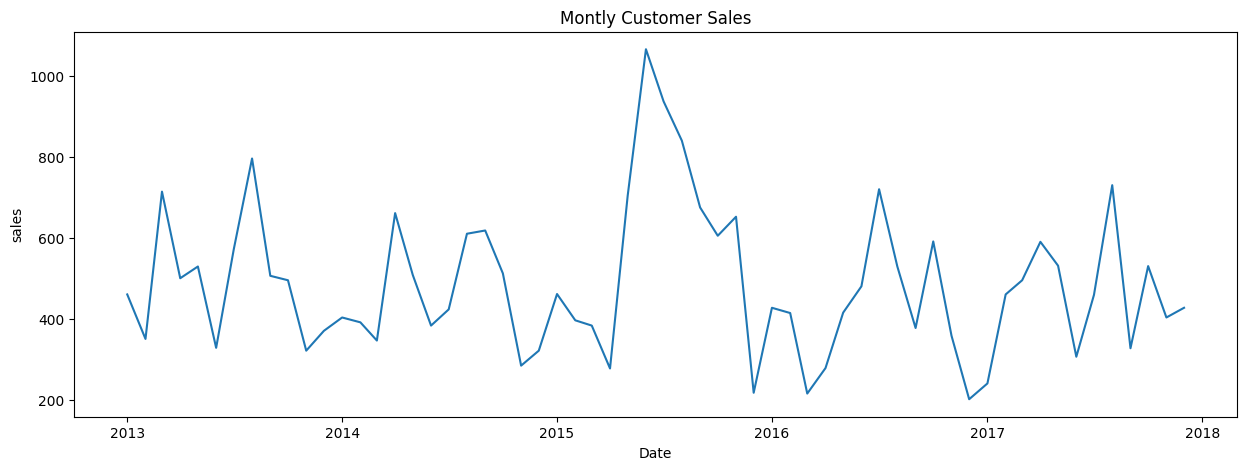

In [173]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("sales")
plt.title("Montly Customer Sales")
plt.show()

In [174]:
# Sales_diff = Selisih Total Penjualan Dengan Bulan Sebelumnya (Increase (+) atau Decrease (-) )
# Contoh Sales_diff pada Row 2 date 2013-03-01 didapatkan dari
# jumlah sales pada date 2013-03-01 (617382) - date 2013-02-01 (459417) didapatkan sales_diff = 157965.0

monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,351,-110.0
2,2013-03-01,715,364.0
3,2013-04-01,501,-214.0
4,2013-05-01,530,29.0
5,2013-06-01,329,-201.0
6,2013-07-01,573,244.0
7,2013-08-01,797,224.0
8,2013-09-01,507,-290.0
9,2013-10-01,496,-11.0
10,2013-11-01,322,-174.0


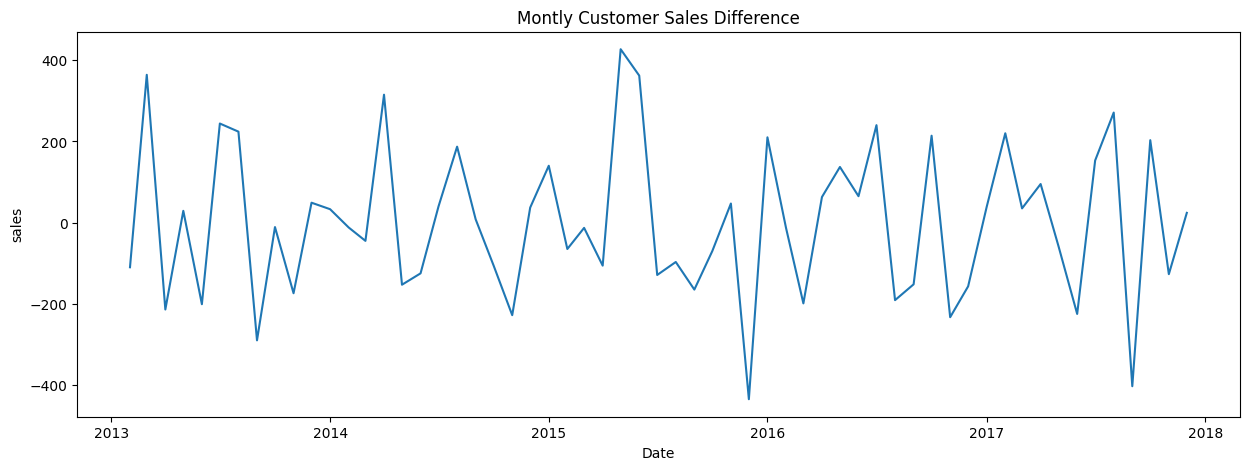

In [175]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff'])
plt.xlabel("Date")
plt.ylabel("sales")
plt.title("Montly Customer Sales Difference")
plt.show()

In [176]:
supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)

In [177]:
for i in range(1,13):
  col_name = 'month_' + str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,-12.0,33.0,49.0,-174.0,-11.0,-290.0,224.0,244.0,-201.0,29.0,-214.0,364.0,-110.0
1,-45.0,-12.0,33.0,49.0,-174.0,-11.0,-290.0,224.0,244.0,-201.0,29.0,-214.0,364.0
2,315.0,-45.0,-12.0,33.0,49.0,-174.0,-11.0,-290.0,224.0,244.0,-201.0,29.0,-214.0
3,-153.0,315.0,-45.0,-12.0,33.0,49.0,-174.0,-11.0,-290.0,224.0,244.0,-201.0,29.0
4,-125.0,-153.0,315.0,-45.0,-12.0,33.0,49.0,-174.0,-11.0,-290.0,224.0,244.0,-201.0
5,40.0,-125.0,-153.0,315.0,-45.0,-12.0,33.0,49.0,-174.0,-11.0,-290.0,224.0,244.0
6,187.0,40.0,-125.0,-153.0,315.0,-45.0,-12.0,33.0,49.0,-174.0,-11.0,-290.0,224.0
7,8.0,187.0,40.0,-125.0,-153.0,315.0,-45.0,-12.0,33.0,49.0,-174.0,-11.0,-290.0
8,-106.0,8.0,187.0,40.0,-125.0,-153.0,315.0,-45.0,-12.0,33.0,49.0,-174.0,-11.0
9,-228.0,-106.0,8.0,187.0,40.0,-125.0,-153.0,315.0,-45.0,-12.0,33.0,49.0,-174.0


In [178]:
# Previous 12 Month
train_data = supervised_data[:-12]
# The Coming 12 Month
test_data = supervised_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (35, 13)
Test Data Shape:  (12, 13)


In [179]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [180]:
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("x_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)
print("x_test shape : ", X_test.shape)
print("y_test shape : ", y_test.shape)

x_train shape :  (35, 12)
y_train shape :  (35,)
x_test shape :  (12, 12)
y_test shape :  (12,)


In [181]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [182]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[202, 241, 461, 496, 591, 532, 307, 460, 731, 328, 531, 404, 428]


In [183]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pre = lr_model.predict(X_test)

In [184]:
lr_pre = lr_pre.reshape(-1,1)
# This is a set matrix - contain the input features of the data, and also the predict output
lr_pre_test_set = np.concatenate([lr_pre, X_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [185]:
result_list= []
for index in range(0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)

In [186]:
# print(predict_df)
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
print("Linaer Regression MSE : ", lr_mse )
print("Linaer Regression MAE : ", lr_mae )
print("Linaer Regression R2 : ", lr_r2 )

Linaer Regression MSE :  217.16853459605122
Linaer Regression MAE :  169.27567422428385
Linaer Regression R2 :  -1.0840820183220008


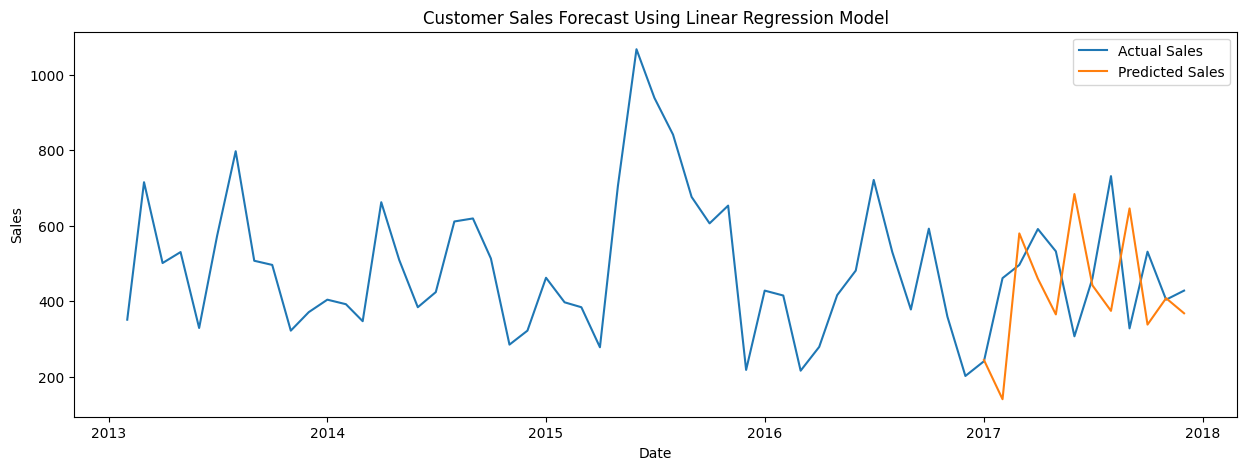

In [187]:
plt.figure(figsize=(15,5))
# Actual Sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])
# Predicted Sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title("Customer Sales Forecast Using Linear Regression Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()